In [1]:
from sackmann import get_data

/home/martin/miniconda3/envs/jax/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# Use this to clone the data if you need it
!git clone https://github.com/JeffSackmann/tennis_atp.git

df = get_data('./tennis_atp/')

fatal: destination path 'tennis_atp' already exists and is not an empty directory.


In [3]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,loser_rank_points,round_number,year,pts_won_serve_winner,pts_won_serve_loser,pts_played_serve_winner,pts_played_serve_loser,spw_winner,spw_loser,spw_margin
0,1968-580,Australian Chps.,Grass,64,G,1968-01-19,1,110023,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-580,Australian Chps.,Grass,64,G,1968-01-19,2,109803,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-580,Australian Chps.,Grass,64,G,1968-01-19,3,100257,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-580,Australian Chps.,Grass,64,G,1968-01-19,4,100105,5.0,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-580,Australian Chps.,Grass,64,G,1968-01-19,5,109966,NaN,NaN,...,NaN,2,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
rel_df = df[df['tourney_date'].dt.year >= 1960]

In [5]:
rel_df.shape

(158394, 58)

In [6]:
# We're going to fit a hierarchical model to rate tennis players.

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

encoder.fit(rel_df['winner_name'].values.tolist() + rel_df['loser_name'].values.tolist())

names = encoder.classes_
winner_ids = encoder.transform(rel_df['winner_name'])
loser_ids = encoder.transform(rel_df['loser_name'])

/home/martin/miniconda3/envs/jax/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/martin/miniconda3/envs/jax/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [8]:
from jax_advi.advi import optimize_advi_mean_field
from jax_advi.constraints import constrain_positive

theta_shapes = {
    'player_skills': (len(names)),
    'skill_prior_sd': ()
}

theta_constraints = {
    'skill_prior_sd': constrain_positive
}

In [9]:
len(names)

4763

In [10]:
from jax.scipy.stats import norm
from jax import jit
from jax.nn import log_sigmoid
import jax.numpy as jnp

@jit
def log_prior_fun(theta):
    
    # Prior
    skill_prior = jnp.sum(norm.logpdf(theta['player_skills'], 0., theta['skill_prior_sd']))
    
    # hyperpriors
    hyper_sd = norm.logpdf(theta['skill_prior_sd'])
    
    return skill_prior + hyper_sd

def log_lik_fun(theta, winner_ids, loser_ids):
    
    logit_probs = theta['player_skills'][winner_ids] - theta['player_skills'][loser_ids]
    
    return jnp.sum(log_sigmoid(logit_probs))

In [11]:
from functools import partial

curried_lik = jit(partial(log_lik_fun, winner_ids=winner_ids, loser_ids=loser_ids))

In [12]:
result = optimize_advi_mean_field(theta_shapes, log_prior_fun, curried_lik, 
                                  constrain_fun_dict=theta_constraints, verbose=True, M=25)

160192.84 41637.45
151053.33 3800.0847
150716.66 3660.9846
149508.72 3109.3862
147309.02 15814.716
146519.44 4730.4736
142771.6 9055.841
130717.62 9677.66
117473.34 825.91644
114491.21 1212.0094
112448.09 1305.3463
107510.9 640.66296
106780.76 821.0406
105487.83 329.28558
104906.734 246.87854
104449.88 243.94986
103870.32 404.99768
105215.21 3475.148
103817.17 604.64716
103720.53 212.69493
103692.79 163.6832
103628.45 166.92772
103528.88 185.82805
103387.42 188.8678
103236.17 171.15692
103206.945 230.38036
103074.44 61.2906
103049.75 67.62697
103023.805 129.54457
104200.34 5845.8374
103022.6 70.020325
103010.695 57.690212
102984.93 171.8549
102972.39 136.13675
102959.01 51.34328
102951.0 52.4712
102940.695 55.538105
102912.57 63.870174
102886.01 56.010197
102901.85 135.21936
102875.76 65.29339
102862.13 27.458694
102855.74 107.00838
102877.95 572.4206
102853.4 66.54251
102851.49 27.912346
102849.984 23.975624
102848.875 25.543404
102844.97 85.36053
102842.17 23.189137
102840.95 17.4845

In [20]:
import pandas as pd
from jax_advi.advi import get_posterior_draws

advi_draws = get_posterior_draws(result['free_means'], result['free_sds'], theta_constraints, n_draws=4000)

mean_skills_advi = pd.Series(advi_draws['player_skills'].mean(axis=0), index=names).sort_values(ascending=False)
advi_sds = advi_draws['player_skills'].std(axis=0)

In [21]:
print(mean_skills_advi.head(20).round(2).to_markdown())

|                       |    0 |
|:----------------------|-----:|
| Novak Djokovic        | 3.56 |
| Rafael Nadal          | 3.43 |
| Roger Federer         | 3.32 |
| Ivan Lendl            | 3.22 |
| Bjorn Borg            | 3.18 |
| John McEnroe          | 3.17 |
| Jimmy Connors         | 3.14 |
| Rod Laver             | 3.03 |
| Andy Murray           | 2.94 |
| Pete Sampras          | 2.89 |
| Boris Becker          | 2.79 |
| Andre Agassi          | 2.74 |
| Stefan Edberg         | 2.73 |
| Andy Roddick          | 2.72 |
| Juan Martin del Potro | 2.68 |
| Arthur Ashe           | 2.64 |
| Ken Rosewall          | 2.61 |
| Guillermo Vilas       | 2.59 |
| John Newcombe         | 2.54 |
| Mats Wilander         | 2.47 |


In [22]:
# Compare with stan
from stan_utils import load_stan_model_cached

stan_model = load_stan_model_cached('stan_tennis.stan')

In [23]:
stan_data = {
    'N': winner_ids.shape[0],
    'P': len(names),
    'winner_ids': winner_ids + 1,
    'loser_ids': loser_ids + 1
}

In [24]:
import numpy as np

# Uncomment if you want to fit the Stan model. It takes a while though!
#stan_fit = stan_model.sampling(data=stan_data)
stan_fit = np.load('./stan_samples.npz')

In [25]:
player_skills = stan_fit['player_skills']

In [26]:
mean_skills = player_skills.mean(axis=0)

In [27]:
mean_skills = pd.Series(mean_skills, index=names)

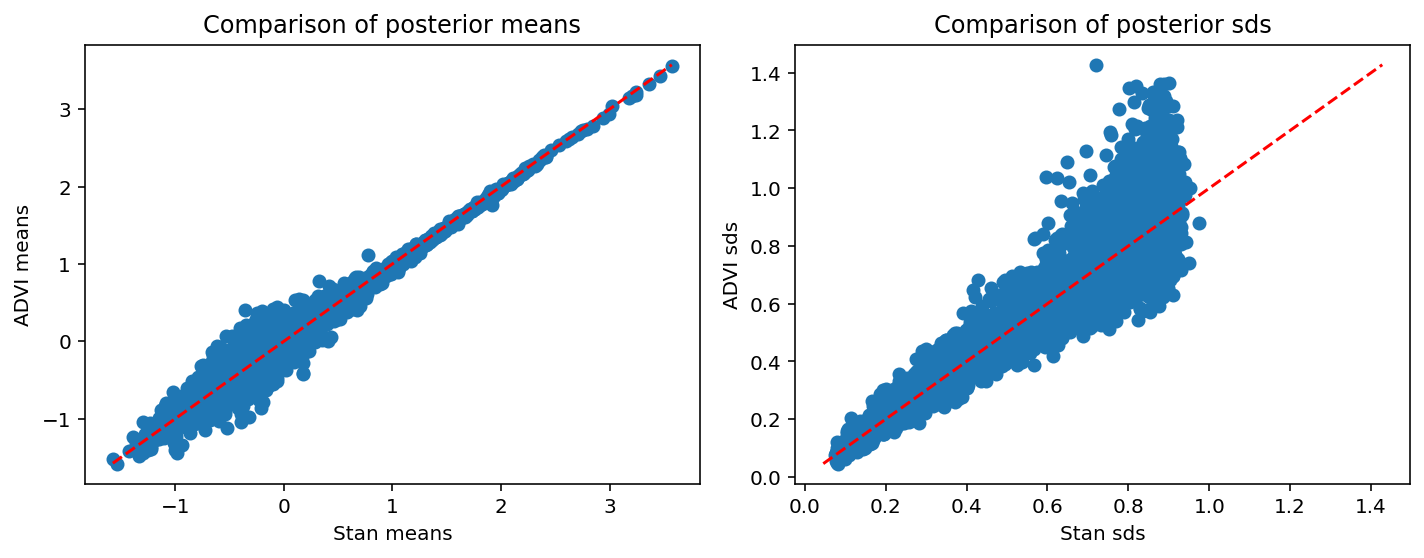

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 2)

ax[0].scatter(mean_skills, mean_skills_advi.loc[mean_skills.index])
ax[0].plot([mean_skills.min(), mean_skills.max()], [mean_skills.min(), mean_skills.max()], color='r', linestyle='--')

ax[1].scatter(player_skills.std(axis=0), advi_sds)
ax[1].plot([advi_sds.min(), advi_sds.max()], [advi_sds.min(), advi_sds.max()], linestyle='--', color='r')

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('ADVI means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('ADVI sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('tennis_comparison.png', dpi=300)

In [29]:
import numpy as np

# Save the Stan samples.
#np.savez('stan_samples', **stan_fit.extract())

In [30]:
# Try Stan's ADVI
vb_result_stan = stan_model.vb(data=stan_data, )

In [31]:
vb_result_stan.keys()

odict_keys(['args', 'inits', 'sampler_params', 'sampler_param_names', 'mean_pars', 'mean_par_names'])

In [32]:
stan_advi_res = [y for x, y in zip(vb_result_stan['mean_par_names'], vb_result_stan['mean_pars']) 
 if 'player_skills[' in x]

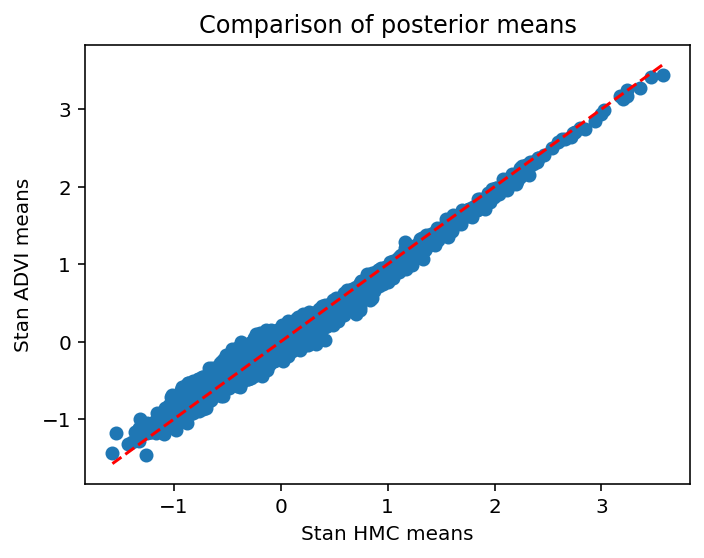

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(mean_skills, stan_advi_res)
plt.plot([mean_skills.min(), mean_skills.max()], [mean_skills.min(), mean_skills.max()], color='r', linestyle='--')

plt.title('Comparison of posterior means')

plt.xlabel('Stan HMC means')
plt.ylabel('Stan ADVI means')

plt.gcf().set_size_inches(5, 4)
plt.gcf().tight_layout()

plt.savefig('tennis_comparison_stan_advi.png', dpi=300)



In [34]:
# LRVB -- experimental
# Warning, this can take a few minutes on a GPU (4.5 on my GTX 2070).
from jax_advi.lrvb import compute_lrvb_covariance, get_posterior_draws_lrvb

lrvb_free_sds, lrvb_cov_mat = compute_lrvb_covariance(
    result['final_var_params_flat'], result['objective_fun'], result['shape_summary'], batch_size=8)

  0%|          | 0/596 [00:00<?, ?it/s]/home/martin/miniconda3/envs/jax/lib/python3.7/site-packages/jax/lax/lax.py:6188: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
100%|██████████| 596/596 [04:16<00:00,  2.32it/s]


In [35]:
# Make draws from the LRVB objective
lrvb_draws = get_posterior_draws_lrvb(np.split(result['final_var_params_flat'], 2)[0],
                                     lrvb_cov_mat, result['shape_summary'], theta_constraints, n_draws=4000)

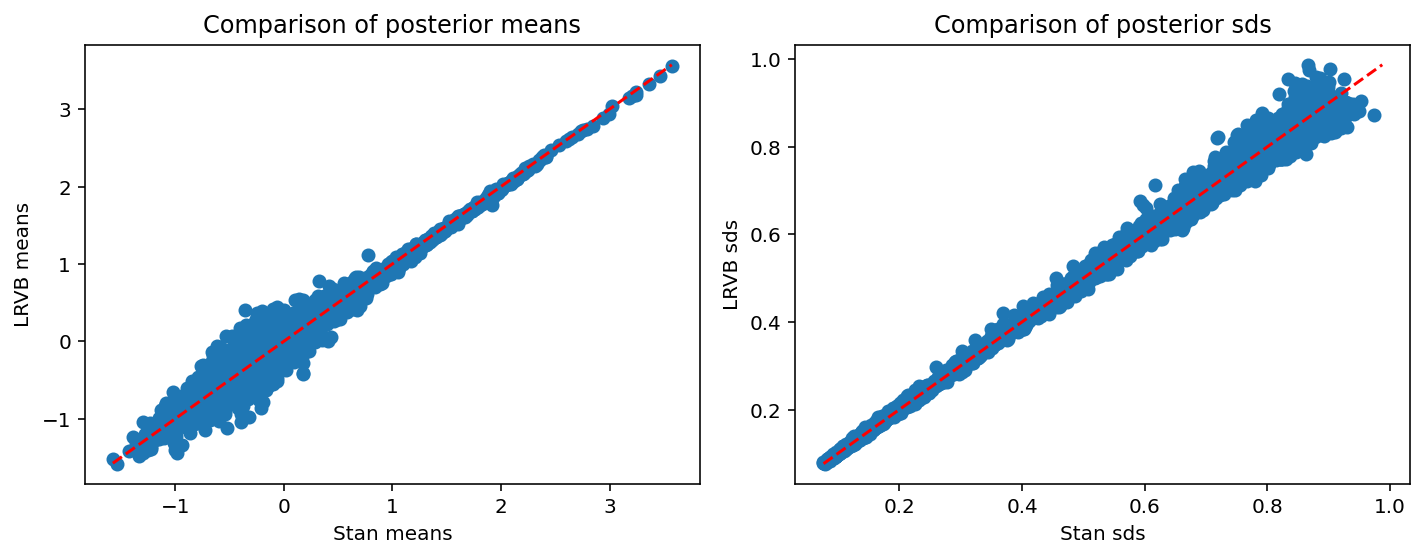

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 2)

advi_sds = lrvb_draws['player_skills'].std(axis=0)

ax[0].scatter(mean_skills, mean_skills_advi.loc[mean_skills.index])
ax[0].plot([mean_skills.min(), mean_skills.max()], [mean_skills.min(), mean_skills.max()], color='r', linestyle='--')

ax[1].scatter(player_skills.std(axis=0), advi_sds)
ax[1].plot([advi_sds.min(), advi_sds.max()], [advi_sds.min(), advi_sds.max()], linestyle='--', color='r')

ax[0].set_title('Comparison of posterior means')
ax[1].set_title('Comparison of posterior sds')

ax[0].set_xlabel('Stan means')
ax[0].set_ylabel('LRVB means')

ax[1].set_xlabel('Stan sds')
ax[1].set_ylabel('LRVB sds')

f.set_size_inches(10, 4)
f.tight_layout()

plt.savefig('tennis_comparison_lrvb.png', dpi=300)